<a href="https://colab.research.google.com/github/DineshGujjeti/Infosys_Springboard_CodeGenie/blob/main/Infosys_Springboard_CodeGenie/milestone2/codegenerator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setup and Installationst**

In [1]:
# Install required libraries
!pip install transformers accelerate bitsandbytes pandas matplotlib seaborn ipywidgets gradio radon tqdm

import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from IPython.display import display, HTML, clear_output
import ipywidgets as widgets
from gradio.blocks import Blocks
import gradio as gr
import re
import radon.complexity as cc
import radon.metrics as metrics
from tqdm.auto import tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 89.6 MB/s eta 0:00:00


# **Secure Hugging Face Login**

In [4]:

from huggingface_hub import notebook_login
try:
    notebook_login()
except Exception as e:
    print(f"Hugging Face login failed (this may be acceptable if all models are public): {e}")

# **Configuration Setup**

In [5]:
MODEL_LIST = [
    {"name": "DeepSeek-Coder-1.3B", "id": "deepseek-ai/deepseek-coder-1.3b-instruct", "dtype": torch.bfloat16, "trust_remote_code": True},
    {"name": "Phi-2-2.7B", "id": "microsoft/phi-2", "dtype": torch.float16, "trust_remote_code": True},
    {"name": "Gemma-2B-IT", "id": "google/gemma-2b-it", "dtype": torch.bfloat16, "trust_remote_code": False}, # Requires login/acceptance
    {"name": "Stable-Code-3B", "id": "stabilityai/stable-code-3b", "dtype": torch.bfloat16, "trust_remote_code": True},
    {"name": "Replit-Code-3B", "id": "replit/replit-code-v1-3b", "dtype": torch.bfloat16, "trust_remote_code": True},
]

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# Configure 4-bit quantization for memory efficiency
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

Using device: cuda


# **Metrics Calculation Function**


In [6]:
def calculate_metrics(code: str) -> dict:
    """Calculates Cyclomatic Complexity (CC), Maintainability Index (MI), and LOC."""

    # 1. Calculate LOC (Lines of Code)
    loc = len(code.splitlines())

    # 2. Extract Python code only (remove markdown/context)
    match = re.search(r"```python\n(.*)```", code, re.DOTALL)
    if match:
        clean_code = match.group(1).strip()
    else:
        # Fallback: assume the whole string is the code
        clean_code = code.strip()

    if not clean_code:
        return {"CC": 0, "MI": 0, "LOC": loc}

    # 3. Calculate CC and MI using Radon
    try:
        # Get function-level CC (blocks of complexity)
        cc_blocks = cc.cc_visit(clean_code)

        # Calculate Maintainability Index for the entire block
        mi_results = metrics.mi_visit(clean_code, multi=True)

        # Average Cyclomatic Complexity (CC)
        if cc_blocks:
            avg_cc = sum(c.complexity for c in cc_blocks) / len(cc_blocks)
            # The 'cc_blocks' might be empty if there are no functions/classes,
            # so we'll default to 1 (base complexity) if it's just sequential code.
            if avg_cc < 1: avg_cc = 1
        else:
            # If no functions/classes, CC is 1 (single path)
            avg_cc = 1

        # Maintainability Index (MI)
        # Radon returns a single MI value for the module/file
        maintainability_index = mi_results[0].mi

        return {
            "CC": round(avg_cc, 2),
            "MI": round(maintainability_index, 2),
            "LOC": loc
        }
    except Exception as e:
        # Catch syntax errors in generated code
        # print(f"Error calculating metrics for code: {e}")
        return {"CC": 99, "MI": 0, "LOC": loc} # Assign poor scores for non-parseable code

# **Test Prompts**

In [7]:
CODE_PROMPTS = [
    "Write a Python function for the QuickSort algorithm.",  # Algorithm
    "Create a class in Python to represent a financial bank account with methods for deposit and withdrawal, ensuring no negative balance.", # OOP/Finance
    "Write a function to read a CSV file using pandas, filter rows where 'Age' is greater than 30, and return the result.", # Data Science/Pandas
    "Generate a Python script to check if a given year is a leap year.", # Simple Logic
    "Write a Python decorator that measures and prints the execution time of a function.", # Advanced Python/Metaprogramming
    "Create a simple Flask web application route that returns 'Hello, World!'", # Web Development/Framework
    "Write a Python function that uses recursion to calculate the factorial of a number.", # Recursion
    "Generate the Python code for a simple Binary Search Tree (BST) Node class.", # Data Structures
    "Write a Python function to check if two strings are anagrams of each other.", # String Manipulation
    "Create a simple thread pool executor in Python to run 5 tasks concurrently.", # Concurrency
]

# **Pre-Loading All AI Models**

In [8]:
models = {}

def load_models(model_list):
    print(f"Starting model loading on {DEVICE}...")
    for model_info in tqdm(model_list, desc="Loading Models"):
        model_name = model_info['name']
        model_id = model_info['id']

        try:
            # Load the tokenizer
            tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=model_info['trust_remote_code'])

            # Load the model with 4-bit quantization
            model = AutoModelForCausalLM.from_pretrained(
                model_id,
                quantization_config=bnb_config,
                device_map="auto", # Automatically distributes model layers to available devices (GPU/CPU)
                torch_dtype=model_info['dtype'],
                trust_remote_code=model_info['trust_remote_code']
            )
            model.eval()
            models[model_name] = {"model": model, "tokenizer": tokenizer, "id": model_id}
            print(f"✅ Loaded {model_name} successfully.")
        except Exception as e:
            print(f"❌ Failed to load {model_name} from {model_id}. Error: {e}")
            print("Skipping this model.")

load_models(MODEL_LIST)

if not models:
    print("\n🚨 CRITICAL: No models loaded. Please check your Hugging Face login and Colab GPU type.")
else:
    print(f"\nSuccessfully loaded {len(models)} models: {list(models.keys())}")

Starting model loading on cuda...


Loading Models:   0%|          | 0/5 [00:00<?, ?it/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/631 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/2.69G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

✅ Loaded DeepSeek-Coder-1.3B successfully.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

✅ Loaded Phi-2-2.7B successfully.


tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

✅ Loaded Gemma-2B-IT successfully.


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/602 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/610M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

✅ Loaded Stable-Code-3B successfully.


tokenizer_config.json:   0%|          | 0.00/400 [00:00<?, ?B/s]

replit_lm_tokenizer.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/replit/replit-code-v1-3b:
- replit_lm_tokenizer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


spiece.model:   0%|          | 0.00/708k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/87.0 [00:00<?, ?B/s]

❌ Failed to load Replit-Code-3B from replit/replit-code-v1-3b. Error: ReplitLMTokenizer has no attribute vocab_size
Skipping this model.

Successfully loaded 4 models: ['DeepSeek-Coder-1.3B', 'Phi-2-2.7B', 'Gemma-2B-IT', 'Stable-Code-3B']


# **UI #1: Benchmark All Models**

In [13]:
# @title 🚀 UI \#1: Benchmark All Models (FINAL CORRECTED ipywidgets implementation)
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
import pandas as pd
from tqdm.auto import tqdm

# --- Core Functions Check (Assuming these are defined in your environment) ---
# If these functions are not defined, the UI cannot work.
# If you get a NameError on these, you MUST re-run Steps 3 and 4.
try:
    _ = generate_code_and_evaluate
except NameError:
    print("🚨 CRITICAL ERROR: The core function 'generate_code_and_evaluate' is not defined.")
    print("Please ensure you have successfully run Step 3 (Configuration) and Step 4 (Pre-Loading Models).")
    # Exit or raise error if critical dependency is missing
    raise

# --- Helper Function to run the benchmark ---
def run_benchmark_ipy(prompt):
    """Runs all loaded models against a single prompt and compiles results for display."""

    # Ensure clear_output is called before any new output, including display(ui1_box)
    clear_output(wait=True)
    display(ui1_box)

    # Initialize html_output for safety
    html_output = "<h2>📊 Benchmark Results</h2>"

    print(f"--- Running Benchmark for Prompt: '{prompt}' ---")

    results = []

    # Run the benchmark for all models in a progress bar
    # Note: Using list(models.keys()) ensures the iteration is safe.
    with tqdm(list(models.keys()), desc="Benchmarking Models") as pbar:
        for model_name in pbar:
            try:
                result = generate_code_and_evaluate(model_name, prompt)
                metrics = result['metrics']

                results.append({
                    "Model": model_name,
                    "CC": metrics['CC'],
                    "MI": metrics['MI'],
                    "LOC": metrics['LOC'],
                    "Code": result['code']
                })
            except Exception as e:
                print(f"Error during generation for model {model_name}: {e}")
                results.append({
                    "Model": model_name,
                    "CC": 999, "MI": 0, "LOC": 0, "Code": f"Error: {e}"
                })


    if not results:
        html_output += "<h3>No results were generated. Check model loading status.</h3>"
    else:
        df = pd.DataFrame(results)

        # 1. Metrics Table
        metrics_df = df[["Model", "CC", "MI", "LOC"]].sort_values(by="MI", ascending=False)
        html_output += "<h3>Aggregated Metrics (Higher MI is Better, Lower CC is Better)</h3>"

        # Style the DataFrame as HTML
        styled_table = (
            metrics_df.style
            .bar(subset=['MI'], color='#5fba7d', align='left')
            .bar(subset=['CC'], color='#d65f5f', align='right')
            .set_properties(**{'font-size': '10pt', 'border': '1px solid black'})
            .set_table_styles([{'selector': 'th', 'props': [('background-color', '#333'), ('color', 'white')]}])
            .to_html()
        )

        html_output += styled_table

        # 2. Individual Code Snippets
        html_output += "<h3>Generated Code Snippets</h3>"
        for index, row in df.iterrows():
            html_output += f"<div style='border: 1px solid #ddd; margin-top: 15px; padding: 10px;'>"
            html_output += f"<h4>{row['Model']} (CC: {row['CC']}, MI: {row['MI']}, LOC: {row['LOC']})</h4>"
            code_display = row['Code'].replace('<', '&lt;').replace('>', '&gt;')
            html_output += f"<pre style='background-color:#f8f8f8; padding:10px; border:1px solid #ddd; white-space: pre-wrap; color: #008000;'>{code_display}</pre>"
            html_output += "</div>"


    display(HTML(html_output))


# --- UI Widgets Definition (Ensuring widgets.HTML is used) ---

# 1. Dropdown for Prompt Selection
prompt_dropdown_1 = widgets.Dropdown(
    options=CODE_PROMPTS,
    value=CODE_PROMPTS[0] if CODE_PROMPTS else None,
    description='Select Prompt:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='800px')
)

# 2. Run Button
run_button_1 = widgets.Button(
    description='Run Full Benchmark',
    button_style='success',
    icon='play',
    layout=widgets.Layout(width='200px')
)

# 3. Titles and Descriptions (FIX: Use widgets.HTML)
title_1 = widgets.HTML('<h2>🚀 UI \#1: Benchmark All Models</h2>')
description_1 = widgets.HTML('Select a test prompt and click the button to run **all** loaded models and compare their generated code and metrics.')


# --- Event Handling ---
def on_run_button_clicked_1(b):
    run_benchmark_ipy(prompt_dropdown_1.value)

run_button_1.on_click(on_run_button_clicked_1)

# --- Layout Arrangement ---
ui1_controls = widgets.VBox([
    description_1,
    prompt_dropdown_1,
    run_button_1
])

# Final container to display
ui1_box = widgets.VBox([title_1, ui1_controls])
display(ui1_box)

--- Running Benchmark for Prompt: 'Write a Python function for the QuickSort algorithm.' ---


Benchmarking Models:   0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/pandas/io/formats/style.py:4040: RuntimeWarning: invalid value encountered in scalar divide
  end = (x - left) / (right - left)
/usr/local/lib/python3.12/dist-packages/pandas/io/formats/style.py:4044: RuntimeWarning: invalid value encountered in scalar divide
  start = (x - left) / (right - left)


,Model,CC,MI,LOC
0,DeepSeek-Coder-1.3B,99,0,28
1,Phi-2-2.7B,99,0,40
2,Gemma-2B-IT,99,0,21
3,Stable-Code-3B,99,0,74


# **UI #2: Inspect Models with Checkboxes (ipywidgets implementation)**

In [16]:
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
import pandas as pd
from tqdm.auto import tqdm

# --- Core Functions Check (Assuming these are defined in your environment) ---
try:
    _ = generate_code_and_evaluate
except NameError:
    print("🚨 CRITICAL ERROR: The core function 'generate_code_and_evaluate' is not defined.")
    raise

# --- Helper Function to run the custom inspection (Unchanged from previous fix) ---
def run_custom_inspection_ipy(prompt, selected_models_list):
    """Runs only the selected models against a single prompt and compiles results for display."""

    clear_output(wait=True)
    display(ui2_box)

    # Initialize html_output for safety
    html_output = "<h2>🔍 Custom Inspection Results</h2>"

    if not selected_models_list:
        display(HTML("<h3>⚠️ Please select at least one model to run.</h3>"))
        return

    print(f"--- Running Custom Inspection for Prompt: '{prompt}' ---")

    results = []

    # Run the inspection for selected models in a progress bar
    with tqdm(selected_models_list, desc="Inspecting Models") as pbar:
        for model_name in pbar:
            try:
                result = generate_code_and_evaluate(model_name, prompt)
                metrics = result['metrics']

                results.append({
                    "Model": model_name,
                    "CC": metrics['CC'],
                    "MI": metrics['MI'],
                    "LOC": metrics['LOC'],
                    "Code": result['code']
                })
            except Exception as e:
                print(f"Error during generation for model {model_name}: {e}")
                results.append({
                    "Model": model_name,
                    "CC": 999, "MI": 0, "LOC": 0, "Code": f"Error: {e}"
                })

    if not results:
        html_output += "<h3>No results were generated. Check model loading status.</h3>"
    else:
        df = pd.DataFrame(results)

        # 1. Metrics Table
        metrics_df = df[["Model", "CC", "MI", "LOC"]].sort_values(by="MI", ascending=False)
        html_output += "<h3>Aggregated Metrics (Higher MI is Better, Lower CC is Better)</h3>"

        # Style the DataFrame as HTML
        styled_table = (
            metrics_df.style
            .bar(subset=['MI'], color='#5fba7d', align='left')
            .bar(subset=['CC'], color='#d65f5f', align='right')
            .set_properties(**{'font-size': '10pt', 'border': '1px solid black'})
            .set_table_styles([{'selector': 'th', 'props': [('background-color', '#333'), ('color', 'white')]}])
            .to_html()
        )
        html_output += styled_table

        # 2. Individual Code Snippets
        html_output += "<h3>Generated Code Snippets</h3>"
        for index, row in df.iterrows():
            html_output += f"<div style='border: 1px solid #ddd; margin-top: 15px; padding: 10px;'>"
            html_output += f"<h4>{row['Model']} (CC: {row['CC']}, MI: {row['MI']}, LOC: {row['LOC']})</h4>"
            code_display = row['Code'].replace('<', '&lt;').replace('>', '&gt;')
            html_output += f"<pre style='background-color:#f8f8f8; padding:10px; border:1px solid #ddd; white-space: pre-wrap; color: #008000;'>{code_display}</pre>"
            html_output += "</div>"

    display(HTML(html_output))


# --- UI Widgets Definition ---

# 1. Dropdown for Prompt Selection
prompt_dropdown_2 = widgets.Dropdown(
    options=CODE_PROMPTS,
    value=CODE_PROMPTS[0] if CODE_PROMPTS else None,
    description='Select Prompt:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='800px')
)

# 2. Model Checkbox List (The New Implementation)
model_checkboxes_list = []
for model_name in list(models.keys()):
    # Create an individual Checkbox widget for each model, checked by default
    checkbox = widgets.Checkbox(
        value=True,
        description=model_name,
        layout=widgets.Layout(width='auto')
    )
    model_checkboxes_list.append(checkbox)

# Group the checkboxes into a VBox
model_checkbox_vbox = widgets.VBox(
    model_checkboxes_list,
    layout=widgets.Layout(border='1px solid lightgray', padding='10px', width='300px')
)

# 3. Run Button
run_button_2 = widgets.Button(
    description='Run Custom Inspection',
    button_style='info',
    icon='search',
    layout=widgets.Layout(width='200px')
)

# 4. Titles and Descriptions (TraitError FIX: Use widgets.HTML)
title_2 = widgets.HTML('<h2>🔍 UI \#2: Inspect Models with Checkbox List</h2>')
description_2 = widgets.HTML('Select specific models to compare their generated code and metrics for a single prompt.')

# --- Event Handling ---
def on_run_button_clicked_2(b):
    # Collect only the model names where the checkbox is checked (value=True)
    selected_models = [
        cb.description for cb in model_checkboxes_list if cb.value
    ]
    run_custom_inspection_ipy(prompt_dropdown_2.value, selected_models)

run_button_2.on_click(on_run_button_clicked_2)

# --- Layout Arrangement ---
# Use an HBox to put the model list next to the prompt/button controls (optional, VBox works too)
control_panel = widgets.VBox([
    description_2,
    prompt_dropdown_2,
    widgets.Label("Models to Compare:"), # New label for the checkbox list
    model_checkbox_vbox,
    run_button_2
])

# Final container to display
ui2_box = widgets.VBox([title_2, control_panel])
display(ui2_box)

--- Running Custom Inspection for Prompt: 'Create a simple Flask web application route that returns 'Hello, World!'' ---


Inspecting Models:   0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/pandas/io/formats/style.py:4040: RuntimeWarning: invalid value encountered in scalar divide
  end = (x - left) / (right - left)
/usr/local/lib/python3.12/dist-packages/pandas/io/formats/style.py:4044: RuntimeWarning: invalid value encountered in scalar divide
  start = (x - left) / (right - left)


,Model,CC,MI,LOC
0,DeepSeek-Coder-1.3B,99,0,15
1,Phi-2-2.7B,99,0,67
2,Gemma-2B-IT,99,0,37
3,Stable-Code-3B,99,0,59


# **Final Analysis and Visualization Report**

--- Starting Full 10-Prompt Benchmark ---


Total Prompts:   0%|          | 0/10 [00:00<?, ?it/s]

Models for Current Prompt:   0%|          | 0/4 [00:00<?, ?it/s]

Models for Current Prompt:   0%|          | 0/4 [00:00<?, ?it/s]

Models for Current Prompt:   0%|          | 0/4 [00:00<?, ?it/s]

Models for Current Prompt:   0%|          | 0/4 [00:00<?, ?it/s]

Models for Current Prompt:   0%|          | 0/4 [00:00<?, ?it/s]

Models for Current Prompt:   0%|          | 0/4 [00:00<?, ?it/s]

Models for Current Prompt:   0%|          | 0/4 [00:00<?, ?it/s]

Models for Current Prompt:   0%|          | 0/4 [00:00<?, ?it/s]

Models for Current Prompt:   0%|          | 0/4 [00:00<?, ?it/s]

Models for Current Prompt:   0%|          | 0/4 [00:00<?, ?it/s]


--- Full Benchmark Complete ---
Aggregated Report (Mean Metrics per Model):


,CC,MI,LOC
Model,,,
DeepSeek-Coder-1.3B,99.0,0.0,24.3
Gemma-2B-IT,99.0,0.0,40.1
Phi-2-2.7B,99.0,0.0,52.8
Stable-Code-3B,99.0,0.0,71.9


/tmp/ipython-input-1136370176.py:43: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipython-input-1136370176.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-1136370176.py:57: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipython-input-1136370176.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-1136370176.py:71: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipython-input-1136370176.py:71: FutureWarning: 

Passing `palette` without assigning `hue`

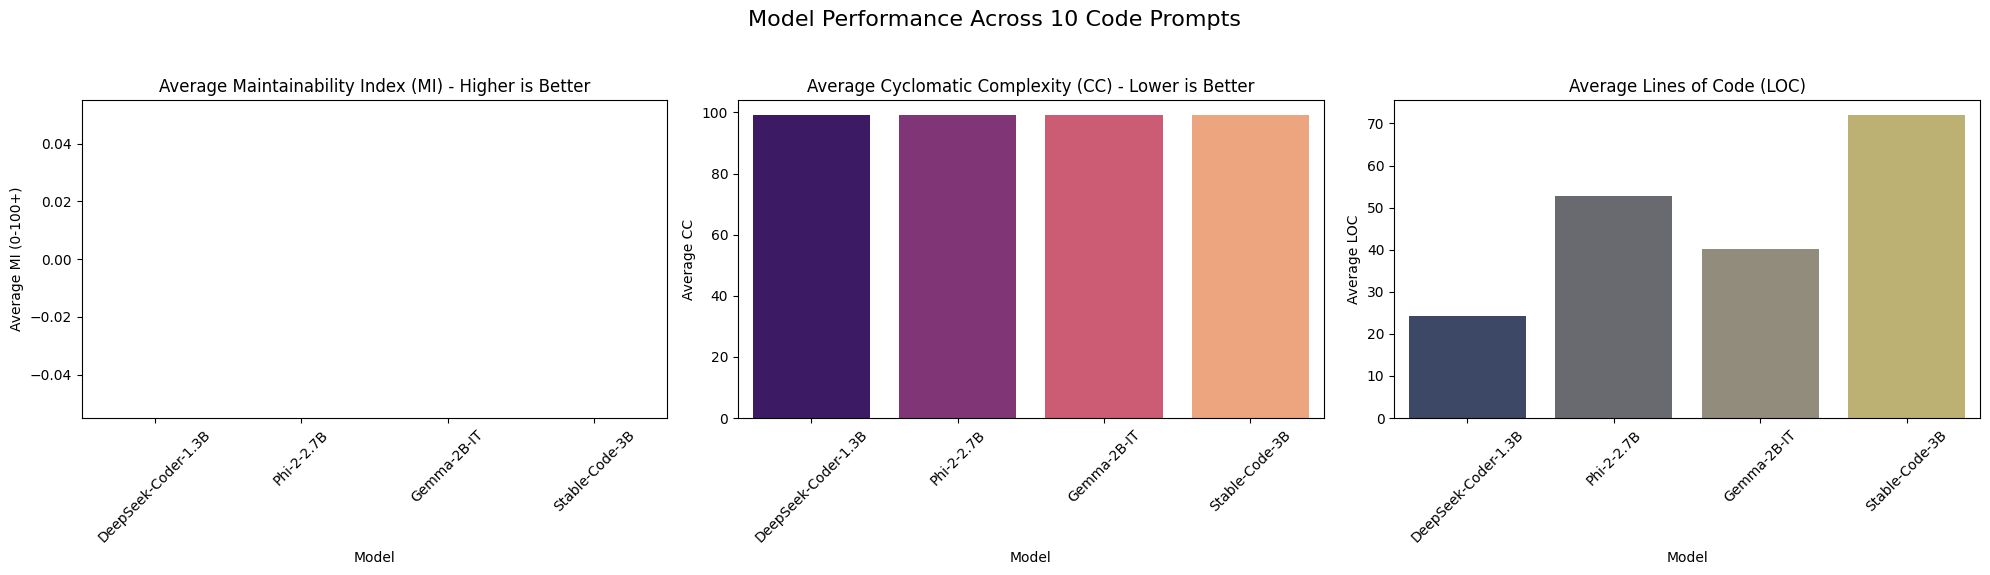




Raw data saved to 'model_performance_report.csv'


In [28]:
# @title 📈 Final Analysis and Visualization Report
# (Content from the original Step 7 cell)

def run_full_report():
    """Runs all models against all 10 prompts and generates the final DataFrame and plots."""

    print("--- Starting Full 10-Prompt Benchmark ---")

    full_results = []

    # Nested loops for all prompts and all models
    for prompt in tqdm(CODE_PROMPTS, desc="Total Prompts"):
        for model_name in tqdm(list(models.keys()), desc="Models for Current Prompt", leave=False):
            # Ensure generate_code_and_evaluate is called with the model_name
            result = generate_code_and_evaluate(model_name, prompt)
            metrics = result['metrics']

            full_results.append({
                "Prompt": prompt,
                "Model": model_name,
                "CC": metrics['CC'],
                "MI": metrics['MI'],
                "LOC": metrics['LOC'],
                "Code": result['code']
            })

    df_report = pd.DataFrame(full_results)

    print("\n--- Full Benchmark Complete ---")
    print("Aggregated Report (Mean Metrics per Model):")

    # Display the final aggregated results
    aggregated_df = df_report.groupby('Model')[['CC', 'MI', 'LOC']].mean().round(2).sort_values(by="MI", ascending=False)
    display(aggregated_df)


    # --- Visualization ---

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    plt.suptitle("Model Performance Across 10 Code Prompts", fontsize=16)

    # Plot 1: Average Maintainability Index (MI)
    sns.barplot(
        x='Model',
        y='MI',
        data=df_report,
        estimator=lambda x: x.mean(),
        ci=None,
        palette='viridis',
        ax=axes[0]
    )
    axes[0].set_title('Average Maintainability Index (MI) - Higher is Better')
    axes[0].set_ylabel('Average MI (0-100+)')
    axes[0].tick_params(axis='x', rotation=45)

    # Plot 2: Average Cyclomatic Complexity (CC)
    sns.barplot(
        x='Model',
        y='CC',
        data=df_report,
        estimator=lambda x: x.mean(),
        ci=None,
        palette='magma',
        ax=axes[1]
    )
    axes[1].set_title('Average Cyclomatic Complexity (CC) - Lower is Better')
    axes[1].set_ylabel('Average CC')
    axes[1].tick_params(axis='x', rotation=45)

    # Plot 3: Average Lines of Code (LOC)
    sns.barplot(
        x='Model',
        y='LOC',
        data=df_report,
        estimator=lambda x: x.mean(),
        ci=None,
        palette='cividis',
        ax=axes[2]
    )
    axes[2].set_title('Average Lines of Code (LOC)')
    axes[2].set_ylabel('Average LOC')
    axes[2].tick_params(axis='x', rotation=45)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    print("\n")

    # Save the raw data for future use
    df_report.to_csv("model_performance_report.csv", index=False)
    print("\nRaw data saved to 'model_performance_report.csv'")

    return df_report



final_report_df = run_full_report()
